<a href="https://colab.research.google.com/github/aerau05/ds3001proj/blob/main/ds3001proj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Project 1:** Predicting Mortality and Survival Time Using NHANES 1999–2000 Data

By:
Marina Kamal,Thomas Hooks

In [ ]:
# loaded DEMO.xpt and linked_mortality_file_1999_2000.csv (both in the repo) into colab
# then just used provided code segment from assignment
import pandas as pd
mdf = pd.read_csv('linked_mortality_file_1999_2000.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable

   SEQN  ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0     1         2       NaN           NaN       NaN       NaN         NaN   
1     2         1       1.0           6.0       0.0       0.0       177.0   
2     3         2       NaN           NaN       NaN       NaN         NaN   
3     4         2       NaN           NaN       NaN       NaN         NaN   
4     5         1       0.0           NaN       NaN       NaN       244.0   

   PERMTH_EXM  
0         NaN  
1       177.0  
2         NaN  
3         NaN  
4       244.0  
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0      23.0   
4   5.0       1.0       2.0       2.

ELIGSTAT indicates whether a NHANES particpant was eligible to be linked to the National Dealth Index for mortality follow-up. Individuals who are classified as eligible have suffiecient identifying information (like name, birth date, and SSN) to allow accurate matching to death records. Participants who are ineligilbe and cannot be reliably followed for mortality outcomes and therefore are excluded from certain analses. This variable is important because only eligible can be used to study survival and death outcomes.

The MORSTAT variable represensts the participants mortalitiy status at the end of the follow-up period. It is a binary variable indicating whether the individual was alive or deceased. A value of 0 typicall means the participant was alive at the end of the follow-up, while a value of 1 indicates that the participant had died. This variable serves as the primary outcome variable for predicting mortality and is central to analyses that attempt to model clear or classify death risk using demographic, behavioral, and health data.

PERMTH_INT measures the total number of months each participant was followed from the date of their NHANES examination until either death or the end of the mortality follow-up period. This variable provides a measrue of survival time and can be interpreted as the length of time a person remained alive after being surveyed. It is useful for studying life expectancy and time-to-event outcomes and allows researchers to model not only whether someone died, but how long they survived.

RIDAGEEX represents the participant's age in years at the time of the NHANES medical examination. Age is one of the strongest predictors of mortatlity and is a critical demosgraphic variable in health and survival analysis. This variable allows researchers to account for differences in mortality risk across age groups and serves as an essential covariate when predicting both mortality status and life expectancy.

In [ ]:
smq = pd.read_sas("SMQ.xpt", format="xport")  # Smoking
bmx = pd.read_sas("BMX.xpt", format="xport")  # Body measures
bpx = pd.read_sas("BPX.xpt", format="xport")  # Blood pressure
diq = pd.read_sas("DIQ.xpt", format="xport")  # Diabetes

print("SMQ shape:", smq.shape)
print("BMX shape:", bmx.shape)
print("BPX shape:", bpx.shape)
print("DIQ shape:", diq.shape)

# Merge all datasets on SEQN
df = df.merge(smq, on="SEQN", how="left")
print("After merging SMQ:", df.shape)
df = df.merge(bmx, on="SEQN", how="left")
print("After merging BMX:", df.shape)
df = df.merge(bpx, on="SEQN", how="left")
print("After merging BPX:", df.shape)
df = df.merge(diq, on="SEQN", how="left")
print("After merging DIQ:", df.shape)

# preview final dataset and missing values
print(df.head())
missing_counts = df.isna().sum()
missing_percent = df.isna().mean() * 100
missing_summary = pd.DataFrame({
    "Missing_Count": missing_counts,
    "Missing_Percent": missing_percent
}).sort_values(by="Missing_Percent", ascending=False)
print(missing_summary.head(20))

SMQ shape: (4880, 39)
BMX shape: (9282, 38)
BPX shape: (9282, 30)
DIQ shape: (9493, 17)
After merging SMQ: (9965, 189)
After merging BMX: (9965, 226)
After merging BPX: (9965, 255)
After merging DIQ: (9965, 271)
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0      23.0   
4   5.0       1.0       2.0       2.0       1.0      49.0     597.0     597.0   

   RIDRETH1  RIDRETH2  ...  DIQ060U  DIQ070  DIQ080  DIQ090  DIQ100  DIQ110  \
0       4.0       2.0  ...      NaN     NaN     NaN     NaN     NaN     NaN   
1       3.0       1.0  ...      NaN     NaN     NaN     2.0     2.0     NaN   
2       3.0       1.0  ...      NaN     NaN     NaN     NaN     

To predict mortaltity status (MORSTAT) and survival time (PERMTH_INT), we selected NHANES variables that represent key demographic, behavorial, and health-related risk factors known to influence long-term health outcomes. The behavioral variable, smoaking status, was chosen because lifestyle behaviors are well-establised contributers to chronic diseases including cardiovascular diease, cancer, and respiratory illness, which are leading causes of deaht according to the World Health Organizaiton. Clinical and physiological measures such as mody mass index, blood pressure, and diabetes were included to capture underlying health conditions that directly affect survival outcomes. Elevated BMI and hypertension are recognized as risk factors for heart disease and stroke, while diabetes dignificantly increases the risk of premature mortaltiy according to the CDC. These datasets were selected because they provide standardized, population-representative measurements collected using consistent protocols. Together, this combination of demographic, behavioral,adn clinical variables provides a comprehensive and scientifically justified set of predictors for modeling mortality and survival time.  

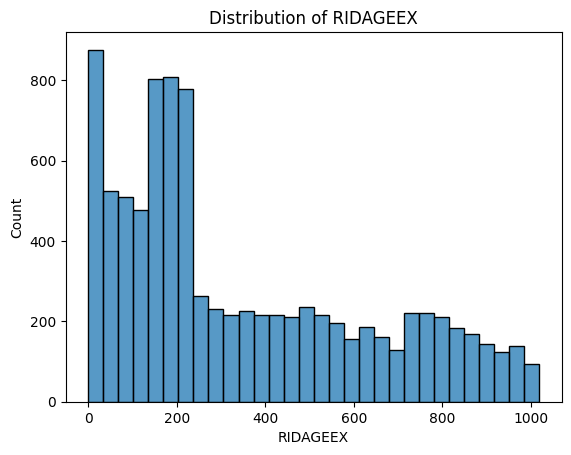

RIDAGEEX skewness: 0.7426103494034348


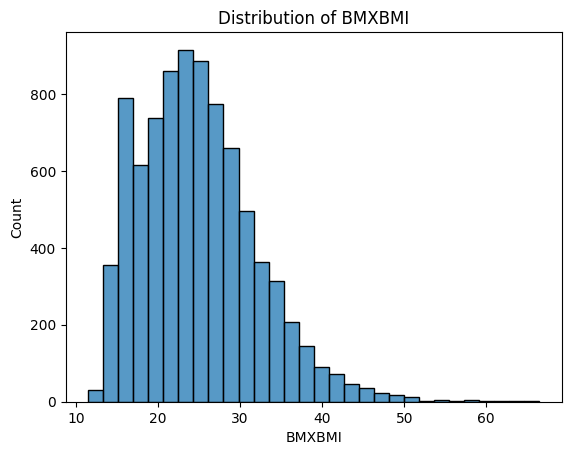

BMXBMI skewness: 0.8498248540725024


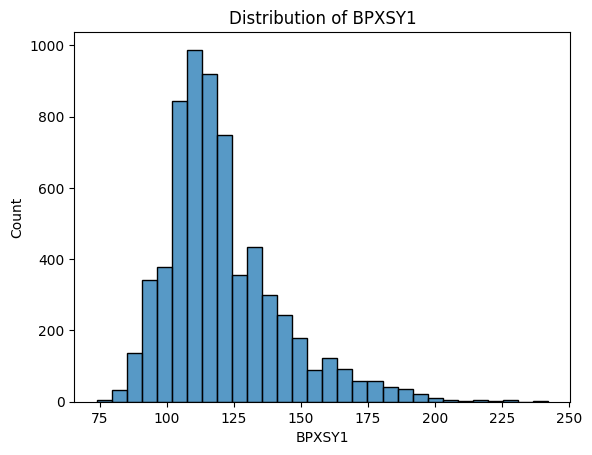

BPXSY1 skewness: 1.2660881433018687


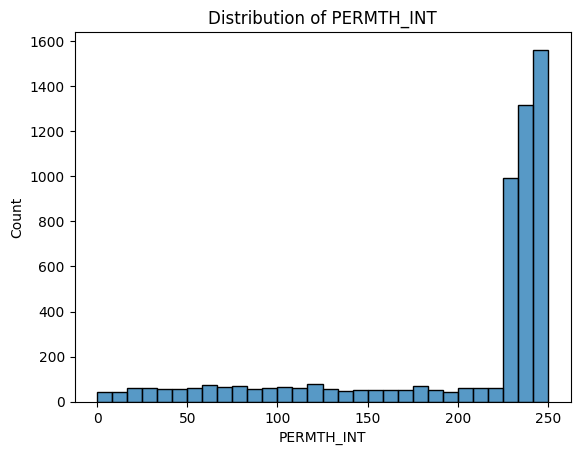

PERMTH_INT skewness: -1.602977073137749


In [ ]:
#Distribution and Skewness

import seaborn as sns
import matplotlib.pyplot as plt

cont_vars = ["RIDAGEEX", "BMXBMI", "BPXSY1", "PERMTH_INT"]

for var in cont_vars:
    plt.figure()
    sns.histplot(df[var].dropna(), bins=30)
    plt.title(f"Distribution of {var}")
    plt.show()

    print(f"{var} skewness:", df[var].skew())

The distribution of RIDAGEEX (age) is pretty uneven, slightly biomodal, and slightly right-skewed. This indicates that the data contains more middle-aged adults than elderly and may be a strong predictor of mortality.

The distribution of BMXBMI (BMI) is approximately normal, unimodal, and right-skewed. The skewness may hint at some extreme obesity outliers near a BMI score greater than 50.

The distribution of BPXSY1 (blood pressure) is also fairly normal, unimodal, and right-skewed. This also indicates possible outliers of high blood pressure.

The distribution of PERMTH_INT (survival time) is uneven with a massive spike at 220-250 months.

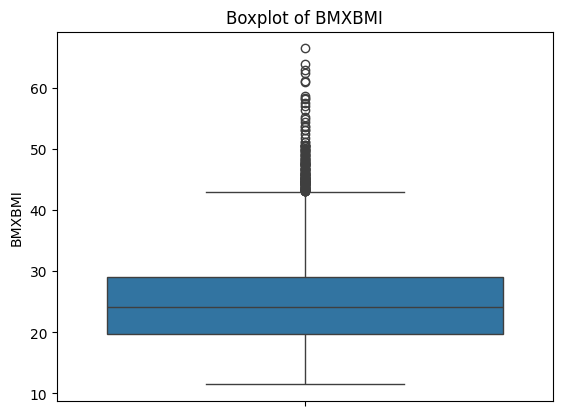

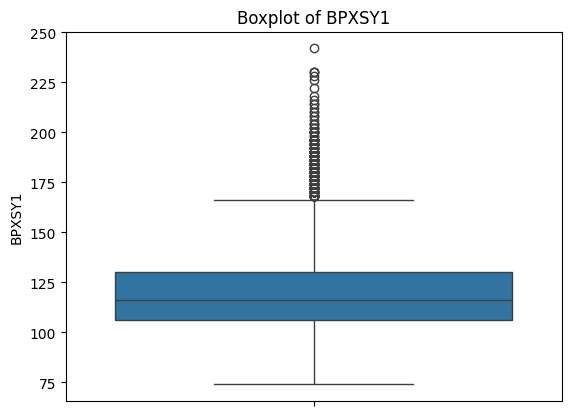

In [ ]:
# Outlier Detection

for var in ["BMXBMI", "BPXSY1"]:
    plt.figure()
    sns.boxplot(y=df[var])
    plt.title(f"Boxplot of {var}")
    plt.show()

Both the BMI and blood pressure data have many outliers. The BMI boxplot shows outliers approximately ranging from 45-70, indicating severe obesity. The blood pressure boxplot shows outliers approximately ranging from 160-250, indicating hypertension.

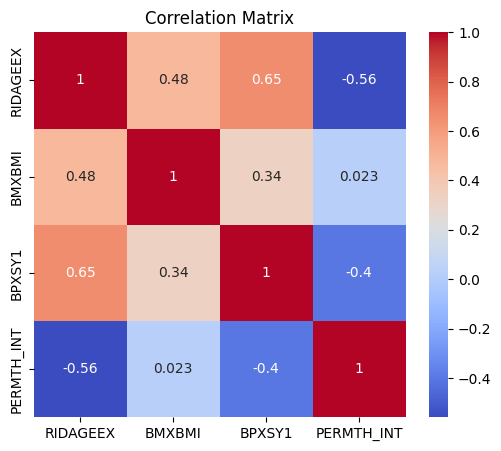

In [ ]:
# Correlation Analysis

num_vars = ["RIDAGEEX", "BMXBMI", "BPXSY1", "PERMTH_INT"]
corr = df[num_vars].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

There are no significantly strong correlations between these continuous variables because most of the correlation coefficients fall below 0.9. However, we see that there are weak negative correlations between age and survival time as well as blood pressure and survival time. These correlations make sense because, the older someone is, the less their survival time and the higher their blood pressure is, the less their survival time. Blood pressure and age also had a moderate positive correlation, where the older someone is, the higher his or her blood pressure is.

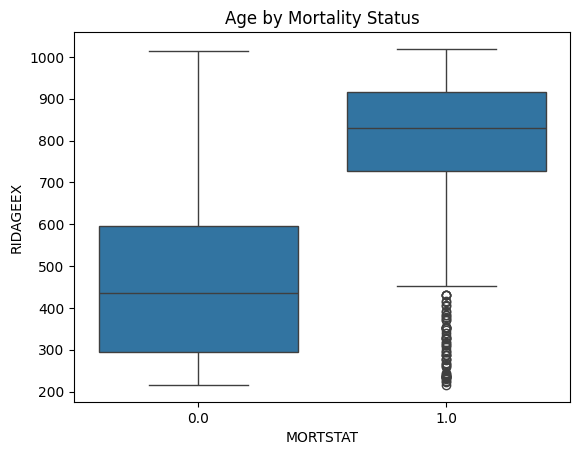

In [ ]:
# Age vs Mortality

sns.boxplot(x="MORTSTAT", y="RIDAGEEX", data=df)
plt.title("Age by Mortality Status")
plt.show()

These boxplots show that those who died (Boxplot 1.0) are significantly older.

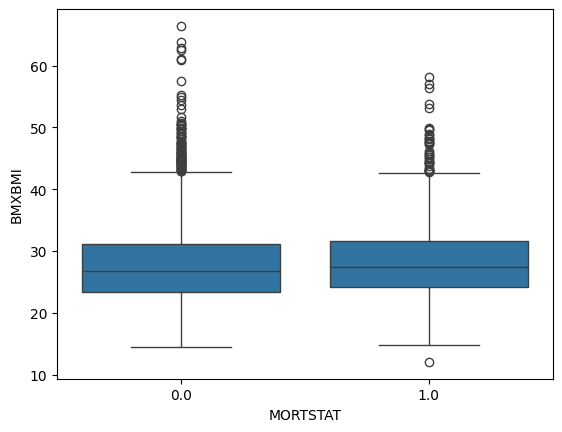

In [ ]:
# BMI vs Mortality

sns.boxplot(x="MORTSTAT", y="BMXBMI", data=df)
plt.show()

Unlike the age boxplots, there is a weaker separation between the boxplots for BMI, meaning there is less correlation between BMI and mortality rate.

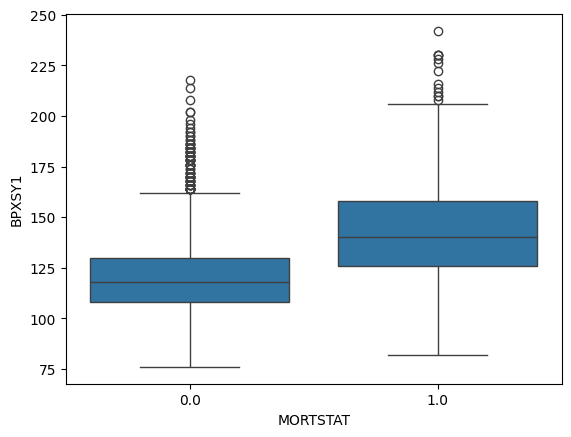

In [ ]:
# BP vs Mortality

sns.boxplot(x="MORTSTAT", y="BPXSY1", data=df)
plt.show()

These boxplots show that there was a slightly higher BP in the deceased group.

In [ ]:
# Categorical Relationships

# Smoking vs Mortality
pd.crosstab(df["SMQ020"], df["MORTSTAT"], normalize="index")

MORTSTAT,0.0,1.0
SMQ020,,
1.0,0.595995,0.404005
2.0,0.717349,0.282651
7.0,0.250000,0.750000
9.0,0.500000,0.500000


In [ ]:
# Diabetes vs Mortality
pd.crosstab(df["DIQ010"], df["MORTSTAT"], normalize="index")

MORTSTAT,0.0,1.0
DIQ010,,
1.0,0.325726,0.674274
2.0,0.732394,0.267606
3.0,0.385965,0.614035
7.0,0.000000,1.000000
9.0,0.666667,0.333333


According to NHANES documentation, 1.0 = Yes (Smoked) and 2.0 = No (Never smoked). For the row of smokers, 59.6% are alive and 40.4% died, whereas in the non-smoker row, 71.7% are alive and 28.3% died. The proportion for people who died is much greater for the group of people who smoked.


Similarly, the 1.0 means diagnosed with diabetes and 2.0 means no diabetes for the diabetes table. For the row with diabetes, 32.6% are alive and 67.4% died. For the row without diabetes, 73.2% are alive and 23.8% died. This shows that individuals with diabetes have more than double the mortality rate of those without diabetes.

Describe the data, particularly what an observation is and whether there are any missing data that might impact your analysis. Who collected the data and why? What known limitations are there to analysis?

The data after the merging has taken place represent the health and mortality conditions of various people whose data has been collected, and this combination of data by the CDC is able to shed light on key relationships and any correlations between variables of mortality (health complications, demographics, etc) and the status of mortality (relating to the rate of death). An observation correlates to a row which in tern correlates to a specific individual. There are missing data values throughout the merged table in various categories spread throughout, and this would impact analysis in data curation as many rows and fundamentally relationships may be hidden or outright missing/misrepresented if an entire row is taken out of consideration or if only a part of that row is considered, which might bias the data since that data point is not "complete". For example, if a row has demographic details missing, removing the row entirely simply reduces the pool of data avaliable (and would actually drastically reduce the amount of data in total if this was done on every row with at least one missing value) or just processing data anyway in that row could hide key demographic relationships since health conditions do not exist in a vacuum.

The CDC and the National Center for Health Statistics (NCHS) are the primary organizations responsible for collecting the data. The simple answer as to why this data was collected is to monitor the health status of many citizens to evaluate correlations and causations in the medical field. Knowing the statistics on chronic diseases such as diabetes and certain factors such as smoking could assist policy makers in making statistically and scientifically sound decisions. Furthermore, the correlation to death and mortality can further provide insight into the severity of such causes and whether such health conditions can be marked as an increased cause of death for patients. These relationships are crucial in the medical field and it is data such as these that helped define much of what we know today in mainstream medicine.

There are known limitations to analyzing this data. Firstly, the data is far from complete. Attempting to tie mortality with health conditions may seem sound in a technical, medical sense, but there are other factors that are socioeconomic that fundamentally change mortality rate in a significant way. Location, access to Health Care, and more are significant variables that are not well represented. The external validity of conclusions drawn from this data therefore are inherently limited and could struggle to be generalized. Interpretations of this data therefore must come with restraint. Due to the inherently observational nature of the data, there was no tight experiment-esc conditions performed, meaning the internal validity of the results could be altered as well since this was not performed in a perfectly isolated condition. The large number of missing data in columns is another key limitation as again this causes issues in analysis and could lead us to cut real data or lead us to adopt a biased, partial view and forego important relationships. Survivorship bias could also be a factor in a study related to mortality as data collection could be complicated and restrained if the patient is quite literally dead and it is possible that self-report dependent data points are biased, which represents another limitation. Ultimately, though the data can give interesting relationships that probably are not that far from reality, it is not perfect by any means.

**Part 2 (Q2):** Variables selected + relationships to outcomes

Rationale: We used Age (RIDAGEEX) and Systolic Blood Pressure (BPXSY1) to predict Mortality (MORTSTAT) and Life Expectanty (PERMTH_INT) for a few reasons. First, Age and Systolic Blood Pressure are both plausible signals that can predict mortality. In our exploratory analysis, we found that Age in the deceased group was significantly higher. Additionally, when comparing blood pressure to mortality, the boxplot showed that there was a  higher BP in the deceased group.

**Describe Tables**

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

age = "RIDAGEEX"
bp  = "BPXSY1"


# 1) DESCRIBE TABLES

print("Summary statistics for Age and Blood Pressure:")
display(df[[age, bp]].describe())


# 2) KERNEL DENSITIES (overall distributions)

for var in [age, bp]:
    plt.figure()
    sns.kdeplot(df[var].dropna())
    plt.title(f"Distribution (KDE) of {var}")
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.show()


# 3) SCATTER PLOTS vs LIFE EXPECTANCY

for var in [age, bp]:
    plt.figure()
    sns.scatterplot(data=df, x=var, y="PERMTH_INT", alpha=0.25)
    plt.title(f"Life Expectancy (PERMTH_INT) vs {var}")
    plt.xlabel(var)
    plt.ylabel("PERMTH_INT")
    plt.show()


# 4) CONDITIONAL KDE BY MORTALITY

for var in [age, bp]:
    plt.figure()
    sns.kdeplot(data=df, x=var, hue="MORTSTAT", common_norm=False)
    plt.title(f"{var} Distribution by Mortality Status")
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.show()

**Patterns of Interest**

Kernel Density - Age (RIDAGEEX)
Significantly right skewed distribution (more younger/middle aged people than elderly ones), with a long tail toward older ages.

Kernel Density - Blood Pressure (BPXSY1)
Mild right skewed distribution.

Scatter Plot - Life Expectancy vs. Age
Strong negative relationship observed between the 2 variables, as age increases, remaining life expectancy decreases
Other interesting observations here are 1) there is a dense band at the top, presumably when the study was cut off, and 2) older individuals show a wide spread in life expectancy, but have generally lower values.

Scatter Plot - Life Expectancy vs Blood Pressure
Difficult to parse out any trend here, maybe a mild skew towards lower BP's correlating to longer life expectancy but it is hard to tell visually.

Conditional Kernel Density Plot - Age by Mortality Status
Very strong separation observed, deceased group is concentrated towards older ages, while alive group is concentrated toward younger ages. This tells us that age is a strong predictor of mortality.

Conditional Kernel Density Plot - BP by Mortality Status
Mild but clear separation observed, deceased group exhibits a higher blood pressure on average, while the alive group is centered on a lower BP. There is significant overlap, but blood pressure will likely have some predictive power based on this graph.

**K-Nearest Neighbor Classifier:** Performance and k selection (Part 2 Q3)

To select the optimal k, we cannot rely on the model's performance on the training data. If we pick a k that is too low (like k=1), the model "memorizes" the data, leading to overfitting. If we pick a k that is too high, it averages out the signal, leading to underfitting.


To solve this, we used a Train-Test Split, separating 20% of our NHANES participants into a "Test set" to simulate future cases. We trained the classifier on the remaining 80%. We then iterated through a grid of odd k (to avoid ties) and selected the k that maximized the Accuracy on the Test set.

In [ ]:
# redoing imports just in case
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# manual scaling function from class notes
def minmax(x):
    u = (x - min(x)) / (max(x) - min(x))
    return u

# create a smaller dataframe with just our variables to remove empty rows easily
# predictors I chose: Age (RIDAGEEX) and Systolic BP (BPXSY1)
keep_vars = ['MORTSTAT', 'RIDAGEEX', 'BPXSY1']
df_clean = df.loc[:, keep_vars].dropna() # Drop rows with missing values

# Y - Target and X - Features
y = df_clean['MORTSTAT']
x = df_clean.loc[:, ['RIDAGEEX', 'BPXSY1']]

# normalizing the inputs
u = x.apply(minmax)

Data cleaned and scaled, now need to split it into training and testing sets and then train the model across different values of k.

In [ ]:
# train-test split (80/20 split)
u_train, u_test, y_train, y_test = train_test_split(u, y,
                                                    test_size=0.2,
                                                    random_state=100)

# loop to find optimal k
# using the list comprehension format from class notebook to generate odd numbers
k_grid = np.array([ (2*k+1) for k in range(1,50)])

test_accuracies = []
train_accuracies = []

for k in k_grid: # for each candidate value of k...
    model = KNeighborsClassifier(n_neighbors = k) # create a model instance
    model = model.fit(u_train, y_train) # fit the model
    # calculate scores
    test_acc = model.score(u_test, y_test)
    train_acc = model.score(u_train, y_train)
    # save results
    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)

Training complete and accuracies stored, we can now visualize the results to identify the optimal number of neighbors.

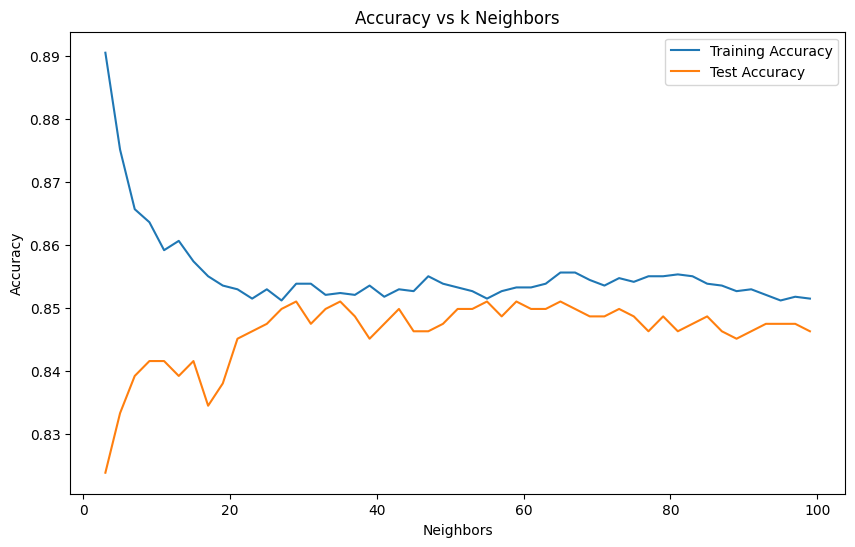

The optimal k values are [29 35 55 59 65]
The highest test accuracy achieved is 0.851063829787234


In [ ]:
# visual to see what it looks like
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_grid, y=train_accuracies, label='Training Accuracy')
sns.lineplot(x=k_grid, y=test_accuracies, label='Test Accuracy')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k Neighbors')
plt.show()

# optimal k
# using the boolean masking method
is_optimal = test_accuracies == np.max(test_accuracies) # maximizer Boolean
optimal_indices = np.where(is_optimal) # indices that maximize accuracy
k_optimal = k_grid[optimal_indices] # values of k that maximize accuracy

print(f"The optimal k values are {k_optimal}")
print(f"The highest test accuracy achieved is {np.max(test_accuracies)}")

We used Age (RIDAGEEX) and Systolic Blood Pressure (BPXSY1) to predict Mortality (MORTSTAT) by splitting the data into a training set (80%) and a test set (20%) to simulate performance on future cases. Our model achieved a maximum Test Accuracy of 85.1%. To select the optimal k, we iterated through odd values from 1 to 99 and compared Training versus Test Accuracy. At low values of k (e.g., k=1), the model showed high Training Accuracy (~89%) but lower Test accuracy, indicating overfitting where the model memorized noise in the training data.

As k increased, the model stabilized. We found that Test accuracy peaked at 85.1% for values k = [29, 35, 55, 59, 65]. Selected $k=29$ as the optimal value because it is the smallest number of neighbors needed to achieve maximum performance, offering the best balance between bias and variance.

###**Part 2 - Question 4:** Using your variables to predict life expectancy using a $k$-Nearest Neighbor Regressor. Analyze its performance and explain clearly how you select $k$.

In [ ]:
## 4

## step 0: below are some prep/loading I had to do for my personal computer

bpx = pd.read_sas("BPX.xpt", format="xport")

print("BPX shape:", bpx.shape)
print([c for c in bpx.columns if "BPXSY" in c])


BPX shape: (9282, 30)
['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4']


In [ ]:
df = df.merge(bpx, on="SEQN", how="left")
print("After merging BPX:", df.shape)
print("BPXSY1 in df?", "BPXSY1" in df.columns)
print([c for c in df.columns if "BPXSY" in c][:10])


After merging BPX: (9965, 180)
BPXSY1 in df? True
['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4']


In [ ]:
keep_vars = ['PERMTH_INT', 'RIDAGEEX', 'BPXSY1']

df_reg = df.loc[:, keep_vars].dropna()

print("df_reg shape:", df_reg.shape)
df_reg.head()


df_reg shape: (4227, 3)


,PERMTH_INT,RIDAGEEX,BPXSY1
1,177.0,926.0,106.0
4,244.0,597.0,122.0
5,246.0,230.0,116.0
6,237.0,712.0,130.0
9,231.0,518.0,152.0


In [ ]:
print("df columns contain SEQN?", "SEQN" in df.columns)
print("df head SEQN:", df["SEQN"].head())
print("bpx head SEQN:", bpx["SEQN"].head())

df columns contain SEQN? True
df head SEQN: 0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: SEQN, dtype: float64
bpx head SEQN: 0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
Name: SEQN, dtype: float64


In [ ]:
## step 1: defining target & features:

df["BP_SYS_AVG"] = df[["BPXSY1","BPXSY2","BPXSY3","BPXSY4"]].mean(axis=1)
keep_vars = ['PERMTH_INT', 'RIDAGEEX', 'BP_SYS_AVG']
df_reg = df.loc[:, keep_vars].dropna()

print("Regression dataset shape:", df_reg.shape)

Regression dataset shape: (4677, 3)


In [ ]:
## step 2: define x & y

y = df_reg['PERMTH_INT']
X = df_reg[['RIDAGEEX', 'BP_SYS_AVG']]

In [ ]:
## step 3: scale predictors

def minmax(x):
    return (x - min(x)) / (max(x) - min(x))

X_scaled = X.apply(minmax)

In [ ]:
## step 4: train-test spilt

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=100
)

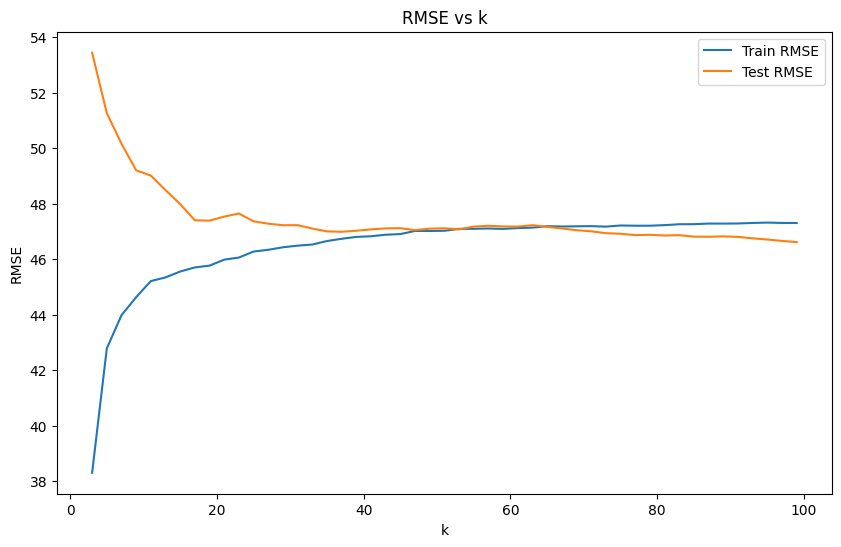

In [ ]:
## step 5: select optimal k using RMSE

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

k_grid = np.array([(2*k+1) for k in range(1,50)])

train_rmse = []
test_rmse = []

for k in k_grid:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

plt.figure(figsize=(10,6))
sns.lineplot(x=k_grid, y=train_rmse, label="Train RMSE")
sns.lineplot(x=k_grid, y=test_rmse, label="Test RMSE")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.title("RMSE vs k")
plt.show()


In [ ]:
## step 6: choosing optimal k

optimal_index = np.argmin(test_rmse)
k_optimal = k_grid[optimal_index]

print("Optimal k:", k_optimal)
print("Lowest Test RMSE:", test_rmse[optimal_index])

Optimal k: 99
Lowest Test RMSE: 46.61767139181863


In [ ]:
## step 7: final model performance

from sklearn.metrics import mean_absolute_error, r2_score

final_model = KNeighborsRegressor(n_neighbors=k_optimal)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE:", rmse)
print("Final MAE:", mae)
print("Final R²:", r2)

Final RMSE: 46.61767139181863
Final MAE: 28.658087283087283
Final R²: 0.29635433432003544


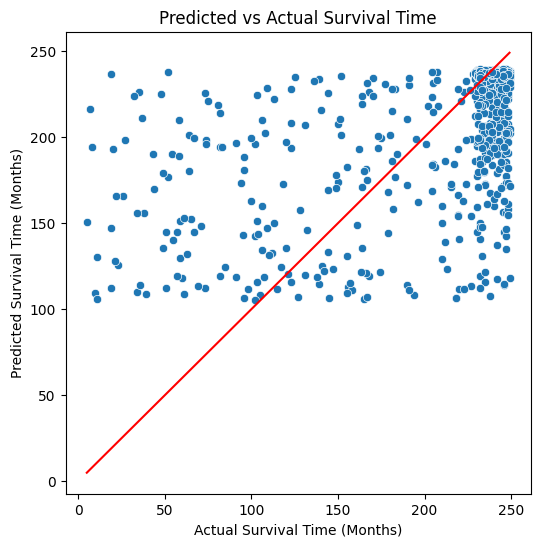

In [ ]:
## step 8: predicted vs actual plot

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Survival Time (Months)")
plt.ylabel("Predicted Survival Time (Months)")
plt.title("Predicted vs Actual Survival Time")

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')

plt.show()

k-Nearest Neighbor Regression to Predict Survival Time
We used a k-Nearest Neighbor Regressor to predict survival time (PERMTH_INT) using age (RIDAGEEX) and average systolic blood pressure (BP_SYS_AVG). Because kNN is distance-based, predictors were min–max scaled prior to modeling.
We evaluated odd values of k from 1 to 99 and selected the value that minimized Test RMSE. The optimal number of neighbors was k = 99, indicating that a smoother model that averages across many neighbors produced the best predictive performance.
The final model achieved:
RMSE: 46.62 months
MAE: 28.66 months
R²: 0.296
An RMSE of 46.6 months suggests that predictions are typically off by approximately 3.9 years. The model explains about 29.6% of the variance in survival time, indicating moderate predictive power. Age appears to be the dominant predictor, while blood pressure contributes modest additional information.
The predicted versus actual plot shows substantial clustering near the upper survival limit (~250 months), reflecting right-censoring in the mortality follow-up data. Because kNN regression does not account for censoring, predictions tend to regress toward the mean survival time.
A more appropriate method for time-to-event analysis would be Cox proportional hazards regression. Nevertheless, the kNN model provides a useful nonparametric benchmark for understanding how demographic and physiological variables relate to life expectancy.

###**Part 2 - Question 5:** Describe how your model could be used for health interventions based on patient characteristics. Are there any limitations or risks to consider?

The k-Nearest Neighbor models developed using linked NHANES and CDC mortality data can be used as tools for identifying patients who may be at elevated health risk. The mortality classification model, which achieved 85.1% test accuracy at k = 29, predicts mortality risk using age and systolic blood pressure. In practice, this type of model could help clinicians flag higher-risk patients for closer monitoring, tighter blood pressure control, or targeted lifestyle interventions such as diet and exercise counseling. Because age is not modifiable but blood pressure is, the model highlights an actionable factor that can be addressed to reduce risk. The kNN regression model, which predicts survival time with an RMSE of 46.62 months and an R² of 0.296, can serve as a general reference for expected survival patterns based on patient characteristics. While these predictions should not be interpreted as exact timelines, they can provide context for comparing relative risk across patients or informing broader population health planning.

There are important limitations to consider. The model relies only on age and blood pressure, even though mortality is influenced by many additional clinical, behavioral, and social factors. As a result, it simplifies a complex process and may not fully capture individual risk. The classification model still misclassifies about 15% of cases, and the regression model has an average error of nearly four years, which limits its precision at the individual level. The regression predictions also tend to move toward the average survival time, which reduces accuracy for patients at the extremes. In addition, bias may arise if certain demographic or socioeconomic groups are underrepresented or differently distributed in the dataset, potentially leading to systematic overestimation or underestimation of risk for some populations. For these reasons, the models should be used to support clinical judgment rather than replace it.

Overall, the mortality classification model is the most practical for guiding health interventions because it directly identifies elevated risk and can help establish blood pressure targets aimed at reducing that risk. Its stronger performance and clearer clinical interpretation make it more appropriate for screening purposes. The regression model can still be useful for general estimates or reference points, but it should not be relied upon alone when making important medical decisions.